In [11]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os


In [12]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split, DataLoader
import timm  # For EfficientNet

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset from RealWaste/ (without train/val folders)
dataset_path = "realwaste-main/RealWaste"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dynamically into train (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Total images: {len(dataset)} | Train: {len(train_dataset)} | Val: {len(val_dataset)}")


C:\Users\Srirama V Swamy\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total images: 4752 | Train: 3801 | Val: 951


In [13]:
import torch.nn as nn
import torch.optim as optim

# Load pre-trained EfficientNet-B0
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(dataset.classes))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = 100 * correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)


Epoch 1/2 | Loss: 124.4318 | Train Accuracy: 70.51%
Epoch 2/2 | Loss: 41.5984 | Train Accuracy: 88.66%


In [15]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = 100 * correct / len(val_loader.dataset)
    print(f"Validation Accuracy: {val_acc:.2f}%")

evaluate_model(model, val_loader)


Validation Accuracy: 84.54%


In [16]:
torch.save(model.state_dict(), "model.pth")
print("Model saved as model.pth")


Model saved as model.pth


In [17]:
import os

dataset_path = "realwaste-main\RealWaste"  # Update this to your dataset path
class_names = sorted(os.listdir(dataset_path))  # Get class names from folder names
print(class_names)  # Verify the class names


['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


<>:3: SyntaxWarning: invalid escape sequence '\R'
<>:3: SyntaxWarning: invalid escape sequence '\R'
C:\Users\Srirama V Swamy\AppData\Local\Temp\ipykernel_3100\1850365083.py:3: SyntaxWarning: invalid escape sequence '\R'
  dataset_path = "realwaste-main\RealWaste"  # Update this to your dataset path


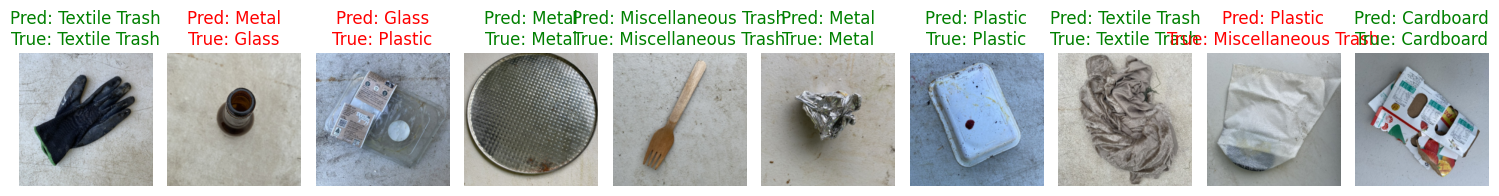

In [18]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, class_names, num_images=5, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Visualize images with their predictions and actual labels.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader containing images to visualize.
        class_names: List of class names.
        num_images: Number of images to visualize.
        device: Device to run inference on ("cuda" or "cpu").
    """
    model.to(device)
    model.eval()
    
    images_shown = 0
    plt.figure(figsize=(15, 12))

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.softmax(outputs, dim=1).argmax(1)  # Apply softmax before argmax

            for i in range(len(images)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return

                # Convert tensor to numpy image
                img = images[i].cpu().permute(1, 2, 0).numpy()
                
                # EfficientNet uses specific normalization, so denormalize accordingly
                mean = torch.tensor([0.485, 0.456, 0.406])
                std = torch.tensor([0.229, 0.224, 0.225])
                img = img * std.numpy() + mean.numpy()  # Unnormalize
                img = img.clip(0, 1)  # Keep values in valid range

                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]

                # Set color for the title based on correctness
                color = "green" if pred_label == true_label else "red"

                # Plot image
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.axis("off")
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

                images_shown += 1

            if images_shown >= num_images:
                plt.tight_layout()
                plt.show()
                return

# Example usage:
visualize_predictions(model, val_loader, class_names, num_images=10)


In [32]:
import os

# Define categories
categories = [
    "Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash",
    "Paper", "Plastic", "Textile Trash", "Vegetation"
]

# Define dataset path
dataset_path = "GarbageDataset"

# Create directories if they don't exist
for category in categories:
    os.makedirs(os.path.join(dataset_path, category), exist_ok=True)

print("Dataset folder structure created successfully.")


Dataset folder structure created successfully.
